# Inference of parameters with latent variables (SEIR model)
In this notebook, we consider the SEIR model with symptomatically and asymptomatically infected. We are trying to infer the parameters of the model 

* $\alpha$ (fraction of asymptomatic infectives), 
* $\beta$ (probability of infection on contact), 
* $\gamma_{E}$ (rate from exposed to infected)
* $\gamma_{I_a}$ (rate of recovery for asymptomatic infected individuals), and
* $\gamma_{I_s}$ (rate of recovery for symptomatic infected individuals) 


when partially observed data ($I_s$ only) from a generated trajectory.

In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

## 1) Generate a trajectory
We generate a test trajectory on a population with two ages groups.

In [2]:
M  = 2              # the population has two age groups
N  = 5e4            # and this is the total population

# correct params
beta  = 0.02        # infection rate
gIa   = 1./7        # recovery rate of asymptomatic infectives
gIs   = 1./7        # recovery rate of asymptomatic infectives
gE    = 0.1         # exposed to infected rate
alpha = np.array([0.5, 0.2])       # fraction of asymptomatic infectives
fsa   = 0.8         # the self-isolation parameter (assumed to be known)

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
E0  = np.array([20, 20])  # each age group has exposed individuals,
Ia0 = np.array([10, 10])  # and asymptomatic infectives,
Is0 = np.array([10, 10])  # and also symptomatic infectives
R0  = np.array([1, 1])    # there are no recovered individuals initially
S0  = Ni - (E0 + Ia0 + Is0 + R0)

Tf = 160
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE, 'fsa':fsa}
true_parameters = parameters

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SEIR(parameters, M, Ni)
data = sto_model.simulate(S0, E0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SEIR_traj.npy', data_array)

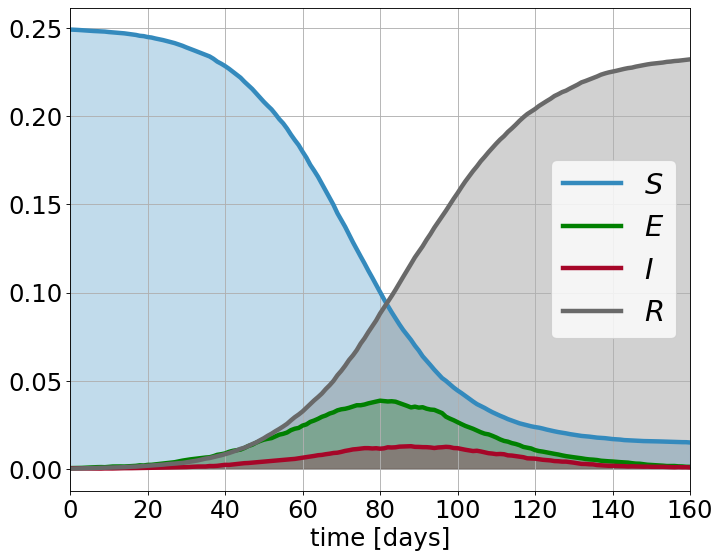

In [3]:
# plot the data and obtain the epidemic curve for one age group 
S  = data_array[:,0]
E  = data_array[:,2]
Ia = data_array[:,4]
Is = data_array[:,6]
t  = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S/N, '-', color="#348ABD", label='$S$', lw=4)

plt.plot(t, E/N, '-', color="green", label='$E$', lw=4)
plt.fill_between(t, 0, E/N, color='green', alpha=0.3)

plt.fill_between(t, 0, Is/N, color='#A60628', alpha=0.3)
plt.plot(t, Is/N, '-', color='#A60628', label='$I$', lw=4)

R=Ni[0]-S-Ia-Is-E; 
plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R/N, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.xlabel("time [days]")
plt.show()

## 2) Inference
We take the first $60$ data points of the $I_\mathrm{s}$ trajectory and use it to infer the parameters of the model.

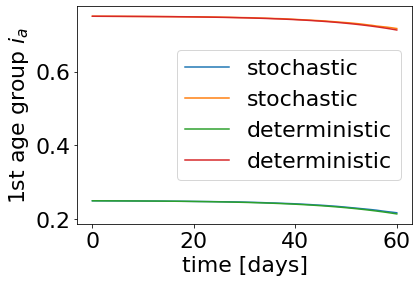

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 60 # can truncate later 
Nf_inference = Tf_inference + 1

x = np.load('latent_SEIR_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 101 # number internal integration steps taken, must be an odd number 


# initialise the estimator 
estimator = pyross.inference.SEIR(parameters, M, fi, int(N), steps)


# make a fltr to get N-R for each age class 
fltr=np.kron([1, 1, 1, 1], np.identity(M))
obs=np.einsum('ij,kj->ki', fltr, x) # This is N-R for each age group
x0=x[0]

# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
det_model = estimator.make_det_model(parameters)
xm = estimator.integrate(x[0,:], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
plt.plot(obs,label="stochastic")
plt.plot(np.einsum('ij,kj->ki', fltr, xm),label="deterministic")
plt.xlabel("time [days]")
plt.ylabel("1st age group $i_a$")
plt.legend()
plt.show()


In [5]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa,'gIs':gIs, 'gE':gE, 'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
end_time = time.time()
print(logp) 
print(end_time - start_time)

-969.3922756116665
0.47513484954833984


In [6]:
# make parameter guesses and set up bounds for each parameter 
eps = 1e-3

beta_g = 0.04
beta_std = 0.04 
beta_bounds = (eps, 1)

gIa_g = 0.2
gIa_std = 0.1 
gIa_bounds = (eps, 1)

gIs_g = 0.2
gIs_std = 0.1 
gIs_bounds = (eps, 1) 

gE_g = 0.1
gE_std = 0.1 
gE_bounds = (eps, 1) 

fsa_g = 0.8 # not inferred 

E0_g = E0/N 
E_std = E0_g*0.3 
bounds_for_E = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g 
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

Is0_g = Is0/N 
Is_std = Is0_g
bounds_for_Is = np.tile([0.1/N, 100/N], M).reshape(M, 2)


# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
bounds = np.array([beta_bounds, gIa_bounds, gIs_bounds, gE_bounds, 
                   *bounds_for_E, *bounds_for_Ia, *bounds_for_Is])
guess = np.array([beta_g, gIa_g, gIs_g, gE_g, *E0_g, *Ia0_g, *Is0_g])
stds = np.array([beta_std, gIa_std, gIs_std, gE_std, *E_std, *Ia_std, *Is_std])
init_fltr = np.repeat([False, True, True, True], M)
param_keys = ['beta', 'gIa', 'gIs', 'gE']
start_time = time.time()
params = estimator.latent_infer_parameters(param_keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=True,
                                    global_max_iter=20, global_ftol_factor=1e2, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 10 (seed=3463022012, Mon Jun  8 20:48:31 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.011381333428391e+03 1.0e+00 8.69e-01  1e-04  9e-02 0:00.3
    2     32 -1.011298636044131e+03 1.2e+00 7.83e-01  9e-05  8e-02 0:00.6
    3     48 -1.005815945226877e+03 1.4e+00 7.80e-01  9e-05  8e-02 0:01.0
   15    240 -1.014939140575510e+03 2.9e+00 7.31e-01  9e-05  7e-02 0:04.2
Optimal value (global minimisation):  -1022.1210746236442
Starting local minimisation...
Optimal value (local minimisation):  -1023.0477672878003
7.611506938934326


In [7]:
# save the parameters 
np.save('SEIR_latent_param.npy', params)

In [8]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs, 'gE':gE,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)
print(parameters, logp)

params = np.load('SEIR_latent_param.npy')
best_estimates = estimator.fill_params_dict(param_keys, params)

logp = estimator.minus_logp_red(best_estimates, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix)

print('\n Best estimates')
print(best_estimates, logp)

print('\n True initial conditions: ') 
print(S0, Ia0, Is0, E0)

partial_inits = params[len(param_keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))
print('R initial = ', N*(fi - np.sum(x0.reshape((4, M)), axis=0)))

True parameters
{'alpha': array([0.5, 0.2]), 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'gE': 0.1, 'fsa': 0.8} -969.3922756116665

 Best estimates
{'alpha': array([0.5, 0.2]), 'beta': 0.0216835564216344, 'gIa': 0.09231858410210635, 'gIs': 0.23819925489105073, 'gE': 0.0859625413978257, 'fsa': array([0.8, 0.8])} -970.0183945554083

 True initial conditions: 
[12459. 37459.] [10 10] [10 10] [20 20]

 Inferred initial conditons: 
[12457 37467    21    15     8     6    10     9]
R initial =  [1. 1.]


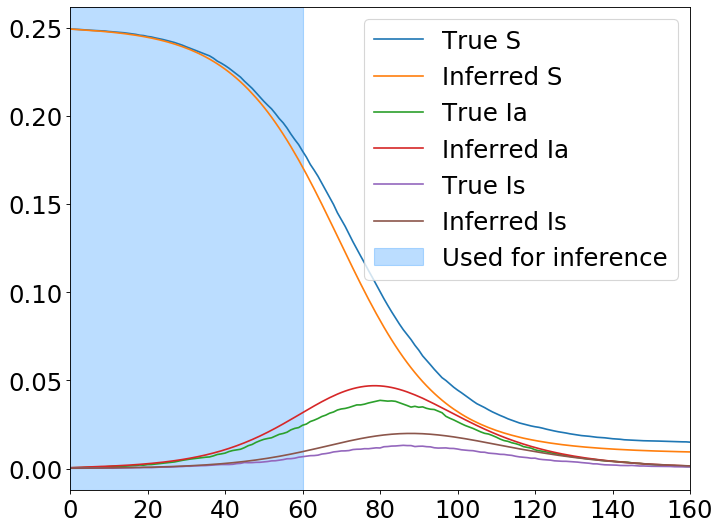

In [9]:
# plot the guessed trajectory and the true trajectory 
estimator.set_params(best_estimates)
det_model = estimator.make_det_model(best_estimates)
partial_inits = params[len(param_keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
estimator.set_det_method('LSODA') # use more stable solver to integrate over the whole traj
x_det = estimator.integrate(x0, 0, Tf, Nf, det_model, contactMatrix)
x = np.load('latent_SEIR_traj.npy').astype('float')/N 
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(x[:,0], label='True S')
plt.plot(x_det[:, 0], label='Inferred S')
plt.plot(x[:,1*M], label='True Ia')
plt.plot(x_det[:, 1*M], label='Inferred Ia')
plt.plot(x[:,2*M], label='True Is')
plt.plot(x_det[:, 2*M], label='Inferred Is')
plt.axvspan(0, Tf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.xlim([0, Tf])
plt.legend()
plt.show()